# All-season Arctic sea ice state variability (prelim, using new summer thickness data)

**Summary**: In this notebook, we provide a preliminary look at all-season thickness estimates from ICESat-2 using 


**Author**: Alek Petty

**Version history**: Version 1 (01/01/2024)

In [1]:
# Regular Python library imports 
import xarray as xr 
import numpy as np
import holoviews as hv
import pandas as pd
import hvplot.pandas # noqa
import pyproj
import scipy.interpolate

# Helper functions for reading the data from the bucket and plotting
from utils.read_data_utils import read_IS2SITMOGR4, read_book_data
from utils.plotting_utils import static_winter_comparison_lineplot, staticArcticMaps, interactiveArcticMaps, compute_gridcell_winter_means, interactive_winter_comparison_lineplot # Plotting utils 

# Plotting dependencies
#%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
# Sets figure size in the notebook
mpl.rcParams['figure.dpi'] = 300 

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 

In [2]:
IS2SITMOGR4_v3 = read_IS2SITMOGR4(data_type='zarr-s3', 
                                   local_data_path='./data/IS2SITMOGR4/', version='V3', 
                                  download=False, persist=True) 

IS2SITMOGR4_v3

load zarr from S3 bucket:  icesat-2-sea-ice-us-west-2
zarr_path: s3://icesat-2-sea-ice-us-west-2/IS2SITMOGR4_V3/zarr/IS2SITMOGR4_V3_201811-202304.zarr/all/


<xarray.Dataset>
Dimensions:                         (time: 38, y: 448, x: 304)
Coordinates:
    latitude                        (y, x) float32 31.1 31.2 ... 34.58 34.47
    longitude                       (y, x) float32 168.3 168.1 ... -10.18 -9.999
  * time                            (time) datetime64[ns] 2018-11-01 ... 2023...
  * x                               (x) float32 -3.838e+06 ... 3.738e+06
  * y                               (y) float32 5.838e+06 ... -5.338e+06
Data variables: (12/27)
    crs                             (time) int32 dask.array<chunksize=(38,), meta=np.ndarray>
    freeboard                       (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    freeboard_int                   (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_density                     (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_density_j22                 (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness                   (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ...                              ...
    snow_density_sm                 (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_density_w99                (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_depth                      (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_depth_int                  (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_depth_mw99                 (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_depth_sm                   (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
Attributes:
    contact:      Alek Petty (akpetty@umd.edu)
    description:  November 2018 to April 2023 (zarr xarray dataset) IS2SITMOG...
    history:      Created 04/12/23
    reference:    Official NSIDC data doi: 10.5067/CV6JEXEE31HF. Derived data...

In [3]:
# Get some map proj info needed for later functions
out_proj = 'EPSG:3411'
mapProj = pyproj.Proj("+init=" + out_proj)

xIS2 = IS2SITMOGR4_v3.x.values
yIS2 = IS2SITMOGR4_v3.y.values
xptsIS2, yptsIS2 = np.meshgrid(xIS2, yIS2)

out_lons = IS2SITMOGR4_v3.longitude.values
out_lats = IS2SITMOGR4_v3.latitude.values

# Set Inner Arctic domain
innerArctic = [1,2,3,4,5,6]


In [4]:
import glob
from datetime import datetime
def add_time_dim_v3(xda):
    """ dummy function to just set current time as a new dimension to concat files over, change later! """
    xda = xda.set_coords(["latitude","longitude", "x", "y"])
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

def read_IS2SITMOGR4_SUMMER(version='V0', local_data_path="./data/IS2SITMOGR4_SUMMER/"): 
    """ Read in IS2SITMOGR4 summer monthly gridded thickness dataset from local netcdf files

    """
    
    print(local_data_path+version+'/*.nc')
    filenames = glob.glob(local_data_path+version+'/*.nc')
    if len(filenames) == 0: 
        raise ValueError("No files, exit")
        return None
    
    dates = [pd.to_datetime(file.split("IS2SIT_SUMMER_01_")[1].split("_")[0], format = "%Y%m")  for file in filenames]
    # Add a dummy time then add the dates I want, seemed the easiest solution
    is2_ds = xr.open_mfdataset(filenames, preprocess = add_time_dim_v3, engine='netcdf4')
            
    is2_ds["time"] = dates

    # Sort by time as glob file list wasn't!
    is2_ds = is2_ds.sortby("time")
    is2_ds = is2_ds.set_coords(["latitude","longitude","x","y"])
    
    is2_ds = is2_ds.assign_coords(longitude=(["y","x"], is2_ds.longitude.values))
    is2_ds = is2_ds.assign_coords(latitude=(["y","x"], is2_ds.latitude.values))
    
    is2_ds = is2_ds.assign_attrs(description="Aggregated IS2SITMOGR4 summer "+version+" dataset.")

    return is2_ds

In [5]:
IS2SITMOGR4_summer_v0 = read_IS2SITMOGR4_SUMMER()
IS2SITMOGR4_summer_v0

./data/IS2SITMOGR4_SUMMER/V0/*.nc


<xarray.Dataset>
Dimensions:                         (time: 11, y: 448, x: 304)
Coordinates:
  * time                            (time) datetime64[ns] 2019-05-01 ... 2021...
    longitude                       (y, x) float32 168.3 168.1 ... -10.18 -9.999
    latitude                        (y, x) float32 31.1 31.2 ... 34.58 34.47
  * x                               (x) float32 -3.838e+06 ... 3.738e+06
  * y                               (y) float32 5.838e+06 ... -5.338e+06
Data variables: (12/26)
    crs                             (time) int32 -2147483647 ... -2147483647
    ice_thickness_sm                (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness_unc               (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    num_segments                    (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    mean_day_of_month               (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_depth_sm                   (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ...                              ...
    ice_thickness_unc_freeboard     (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness_unc_ice_density   (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness_unc_snow_density  (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness_unc_snow_depth    (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    sea_ice_conc                    (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    region_mask                     (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
Attributes:
    contact:      Alek Petty (akpetty@umd.edu)
    description:  Aggregated IS2SITMOGR4 summer V0 dataset.
    history:      Created 20/12/23

In [6]:
IS2SITMOGR4_allseason = IS2SITMOGR4_summer_v0.merge(IS2SITMOGR4_v3)
IS2SITMOGR4_allseason

<xarray.Dataset>
Dimensions:                         (time: 49, x: 304, y: 448)
Coordinates:
  * time                            (time) datetime64[ns] 2018-11-01 ... 2023...
  * x                               (x) float32 -3.838e+06 ... 3.738e+06
  * y                               (y) float32 5.838e+06 ... -5.338e+06
    longitude                       (y, x) float32 168.3 168.1 ... -10.18 -9.999
    latitude                        (y, x) float32 31.1 31.2 ... 34.58 34.47
Data variables: (12/36)
    crs                             (time) float64 dask.array<chunksize=(49,), meta=np.ndarray>
    ice_thickness_sm                (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness_unc               (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    num_segments                    (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    mean_day_of_month               (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_depth_sm                   (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ...                              ...
    ice_type                        (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_density                    (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_density_w99                (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_depth                      (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_depth_int                  (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_depth_mw99                 (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
Attributes:
    contact:      Alek Petty (akpetty@umd.edu)
    description:  Aggregated IS2SITMOGR4 summer V0 dataset.
    history:      Created 20/12/23

In [7]:
# Let's check how the summer data look
# Eventually do this for the annual means too

# Years over which to perform analysis (start year of that summer period)
#years = [x for x in range(2019, 2020+1)]

#thickness_summer_means = compute_gridcell_winter_means(IS2SITMOGR4_v0.ice_thickness_sm_int, years=years)
#staticArcticMaps(thickness_winter_means, dates=thickness_summer_means.time.values,title="", set_cbarlabel = "Sea ice thickness (m)", col_wrap=3, cmap="viridis", vmin=0, vmax=5, out_str='thickness_summer_2019_2020')

In [8]:
def getCS2ubris(mapProj, dataPathCS2, dataset):
    """ Read in the University of Bristol CryoSat-2 sea ice thickness data

    
    Args:
        dataPathCS2 (str): location of data
        
    Returns
        xptsT (2d numpy array): x coordinates on our map projection
        yptsT (2d numpy array): y coordinates on our map projection
        thicknessCS (2d numpy array): monthly sea ice thickness estimates
        

    """
    ubris_f = xr.open_dataset(dataPathCS2+dataset, decode_times=False)

    # Issue with time starting from year 0!
    # Re-set it to start from some other year
    ubris_f = ubris_f.rename({'Time':'time'})
    ubris_f['time'] = ubris_f['time']-679352
    ubris_f.time.attrs["units"] = "days since 1860-01-01"
    decoded_time = xr.decode_cf(ubris_f)

    ubris_f['time']=decoded_time.time
    ubris_f = ubris_f.swap_dims({'t': 'time'})

    # Resample to monthly, note that the S just makes the index start on the 1st of the month
    thicknessCS = ubris_f.resample(time="MS").mean()
    xptsT, yptsT = mapProj(thicknessCS.isel(time=0).Longitude, thicknessCS.isel(time=0).Latitude)
    
    return xptsT, yptsT, thicknessCS

def regridToICESat2(dataArrayNEW, xptsNEW, yptsNEW, xptsIS2, yptsIS2):  
    """ Regrid new data to ICESat-2 grid 
    
    Args: 
        dataArrayNEW (xarray DataArray): Numpy variable array to be gridded to ICESat-2 grid 
        xptsNEW (numpy array): x-values of dataArrayNEW projected to ICESat-2 map projection 
        yptsNEW (numpy array): y-values of dataArrayNEW projected to ICESat-2 map projection 
        xptsIS2 (numpy array): ICESat-2 longitude projected to ICESat-2 map projection
        yptsIS2 (numpy array): ICESat-2 latitude projected to ICESat-2 map projection
    
    Returns: 
        gridded (numpy array): data regridded to ICESat-2 map projection
    
    """
    #gridded = []
    #for i in range(len(dataArrayNEW.values)): 
    gridded = scipy.interpolate.griddata((xptsNEW.flatten(),yptsNEW.flatten()), dataArrayNEW.flatten(), (xptsIS2, yptsIS2), method = 'nearest')
    try:
        gridded = scipy.interpolate.griddata((xptsNEW.flatten(),yptsNEW.flatten()), dataArrayNEW.flatten(), (xptsIS2, yptsIS2), method = 'nearest')
    except:
        try:
            gridded = scipy.interpolate.griddata((xptsNEW,yptsNEW), dataArrayNEW, (xptsIS2, yptsIS2), method = 'nearest')
        except:
            print('Error interpolating..')
    
    return gridded

def regrid_ubris_is2(mapProj, xptsIS2, yptsIS2, out_lons, out_lats, date_range, region_vals, dataPathCS2='/home/jovyan/Data/CS2/UIT/', dataset='ubristol_cryosat2_seaicethickness_nh_80km_v1p7.nc'):

    cs2_ubris = []
    valid_dates=[]

    xptsT_ubris, yptsT_ubris, cs2_ubris_raw = getCS2ubris(mapProj, dataPathCS2, dataset)
    
    for date in date_range:
        
            
        try:
            cs2_ubris_temp_is2grid = regridToICESat2(cs2_ubris_raw.Sea_Ice_Thickness.sel(time=date).values, xptsT_ubris, yptsT_ubris, xptsIS2, yptsIS2) 
            ice_conc_is2grid = regridToICESat2(cs2_ubris_raw.Sea_Ice_Concentration.sel(time=date).values, xptsT_ubris, yptsT_ubris, xptsIS2, yptsIS2)     
            cs2_ubris_temp_is2grid[ice_conc_is2grid<0.5]=np.nan
            
            
        except:
            print(date)
            print('no CS-2 data or issue with gridding, so skipping...')
            continue
        valid_dates.append(date)

        cs2_ubris_temp_is2grid_xr = xr.DataArray(data = cs2_ubris_temp_is2grid, 
                                dims = ['y', 'x'], 
                                coords = {'latitude': (('y','x'), out_lats), 'longitude': (('y','x'), out_lons), 'x': (('x'), xptsIS2[0]),  'y': (('y'), yptsIS2[:, 0])}, 
                                name = 'ice_thickness_cs2_ubris')

        cs2_ubris.append(cs2_ubris_temp_is2grid_xr)

    cs2_ubris = xr.concat(cs2_ubris, 'time')
    #cs2_ubris = cs2_ubris.assign_coords(time=valid_dates)
    cs2_ubris_attrs = {'units': 'meters', 'long_name': 'University of Bristol CryoSat-2 Arctic sea ice thickness', 'data_download': 'https://data.bas.ac.uk/full-record.php?id=GB/NERC/BAS/PDC/01613', 
            'download_date': '09-2022', 'citation': 'Landy, J.C., Dawson, G.J., Tsamados, M. et al. A year-round satellite sea-ice thickness record from CryoSat-2. Nature 609, 517–522 (2022). https://doi.org/10.1038/s41586-022-05058-5'} 
    cs2_ubris = cs2_ubris.assign_coords(time=valid_dates)
    cs2_ubris = cs2_ubris.assign_attrs(cs2_ubris_attrs)  

    return cs2_ubris




In [9]:
start_date_cs2 = "Oct 2018"
end_date_cs2 = "July 2022"
# MS indicates a time frequency of start of the month
date_range_cs2 = pd.date_range(start=start_date_cs2, end=end_date_cs2, freq='MS') 

cs2_ubris = regrid_ubris_is2(mapProj, xptsIS2, yptsIS2, out_lons, out_lats, date_range_cs2, IS2SITMOGR4_allseason.region_mask.values[0], 
                             dataPathCS2='/Users/akpetty/Data/CS2/', dataset='uit_cryosat2_seaicethickness_nh_80km_v1p7.nc')



In [10]:
IS2_CS2_allseason = IS2SITMOGR4_allseason.merge(cs2_ubris)

IS2_CS2_allseason= IS2_CS2_allseason.where(~np.isnan(IS2_CS2_allseason))

# Drop earlier years as get funky after doing the common masking
#IS2_CS2_allseason = IS2_CS2_allseason.where((IS2_CS2_allseason['time.year']<2019), drop=True)

In [11]:
# Apply the same region mask and also drop September/October from the monthly mean analysis
#IS2_CS2_allseason = IS2_CS2_allseason.where(IS2_CS2_allseason.region_mask.isin(innerArctic))
#IS2_CS2_allseason = IS2_CS2_allseason.where(IS2_CS2_allseason.ice_type==1)



### Apply common masking






In [12]:
start_date = "Oct 2018"
end_date = "Apr 2023"
date_range = pd.date_range(start=start_date, end=end_date, freq='MS') 
IS2_CS2_allseason_region_common_list=[]
for date in date_range:
    # Get data for given month
    print(date)
    try:
        monthly_data_to_mask = IS2_CS2_allseason.sel(time=date).copy(deep=True)
    
        if np.isfinite(np.nanmean(monthly_data_to_mask["ice_thickness"])):
            # If there is valid data in the winter IS-2 dataset this month then mask all data using this dataset (need this catch as no NESOSIM data in summer etc)
            monthly_data_to_mask = monthly_data_to_mask.where(monthly_data_to_mask["ice_thickness"]>0.0) 
            
        if np.isfinite(np.nanmean(monthly_data_to_mask["ice_thickness_cs2_ubris"])):
            # If there is valid data in the CS-2 dataset this month then mask all data using this dataset
            monthly_data_to_mask = monthly_data_to_mask.where(monthly_data_to_mask["ice_thickness_cs2_ubris"]>0.0) 
        
        if np.isfinite(np.nanmean(monthly_data_to_mask["ice_thickness_sm"])):
            # If there is valid data in the all-season SM ICESat-2 dataset then mask all data using this dataset (should always apply as data in all months but helps when extending beyond SM)
            monthly_data_to_mask = monthly_data_to_mask.where(monthly_data_to_mask["ice_thickness_sm"]>0.0) 
        
        IS2_CS2_allseason_region_common_list.append(monthly_data_to_mask)
    except:
        continue

IS2_CS2_allseason_region_common = xr.concat(IS2_CS2_allseason_region_common_list, "time")

2018-10-01 00:00:00
2018-11-01 00:00:00
2018-12-01 00:00:00
2019-01-01 00:00:00
2019-02-01 00:00:00
2019-03-01 00:00:00
2019-04-01 00:00:00
2019-05-01 00:00:00
2019-06-01 00:00:00
2019-07-01 00:00:00
2019-08-01 00:00:00
2019-09-01 00:00:00
2019-10-01 00:00:00
2019-11-01 00:00:00
2019-12-01 00:00:00
2020-01-01 00:00:00
2020-02-01 00:00:00
2020-03-01 00:00:00
2020-04-01 00:00:00
2020-05-01 00:00:00
2020-06-01 00:00:00
2020-07-01 00:00:00
2020-08-01 00:00:00
2020-09-01 00:00:00
2020-10-01 00:00:00
2020-11-01 00:00:00
2020-12-01 00:00:00
2021-01-01 00:00:00
2021-02-01 00:00:00
2021-03-01 00:00:00
2021-04-01 00:00:00
2021-05-01 00:00:00
2021-06-01 00:00:00
2021-07-01 00:00:00
2021-08-01 00:00:00
2021-09-01 00:00:00
2021-10-01 00:00:00
2021-11-01 00:00:00
2021-12-01 00:00:00
2022-01-01 00:00:00
2022-02-01 00:00:00
2022-03-01 00:00:00
2022-04-01 00:00:00
2022-05-01 00:00:00
2022-06-01 00:00:00
2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00
2022-10-01 00:00:00
2022-11-01 00:00:00


In [13]:
IS2_CS2_allseason_region_means = IS2_CS2_allseason_region_common.mean(dim=("x","y"), skipna=True, keep_attrs=True).resample(skipna=True, time='1M', label='left',loffset='15D').asfreq()

In [14]:
thickness_plot_1 = IS2_CS2_allseason_region_means.ice_thickness.hvplot.line(grid=True, color='k') * IS2_CS2_allseason_region_means.ice_thickness.hvplot.scatter(marker='x', color='k', size=40, label='IS2 (NSIM)').opts(xlabel="", ylabel="Sea ice thickness (m)", legend_position=("top")) # Overlay scatter plot to add markers
thickness_plot_2 = IS2_CS2_allseason_region_means.ice_thickness_sm.hvplot.line(grid=True, color='b') * IS2_CS2_allseason_region_means.ice_thickness_sm.hvplot.scatter(marker='x', color='b', size=40, label='IS2 (SM-LG)')
thickness_plot_3 = IS2_CS2_allseason_region_means.ice_thickness_cs2_ubris.hvplot.line(grid=True, color='r') * IS2_CS2_allseason_region_means.ice_thickness_cs2_ubris.hvplot.scatter(marker='x', color='r', size=40, label='CS-2_UIT (SM-LG)')
thickness_plot_4 = IS2_CS2_allseason_region_means.ice_thickness_smj22.hvplot.line(grid=True, color='c') * IS2_CS2_allseason_region_means.ice_thickness_smj22.hvplot.scatter(marker='x', color='c', size=40, label='IS2 (SM-LG, J22)')
thickness_plot_5 = IS2_CS2_allseason_region_means.ice_thickness_j22.hvplot.line(grid=True, color='g') * IS2_CS2_allseason_region_means.ice_thickness_j22.hvplot.scatter(marker='x', color='g', size=40, label='IS2 (NSIM, J22)')

snow_depth_plot_1 = IS2_CS2_allseason_region_means.snow_depth.hvplot.line(grid=True, color='k') * IS2_CS2_allseason_region_means.snow_depth.hvplot.scatter(marker='x', color='k', size=40, label='NSIM').opts(xlabel="", ylabel="Snow depth (m)",legend_position=("top")) # Overlay scatter plot to add markers
snow_depth_plot_2 = IS2_CS2_allseason_region_means.snow_depth_sm.hvplot.line(grid=True, color='b') * IS2_CS2_allseason_region_means.snow_depth_sm.hvplot.scatter(marker='x', color='b', size=40, label='SM-LG')

snow_density_plot_1 = IS2_CS2_allseason_region_means.snow_density.hvplot.line(grid=True, color='k') * IS2_CS2_allseason_region_means.snow_density.hvplot.scatter(marker='x', color='k', size=40, label='NSIM').opts(xlabel="", ylabel="Snow density (kg/m3)",legend_position=("top")) # Overlay scatter plot to add markers
snow_density_plot_2 = IS2_CS2_allseason_region_means.snow_density_sm.hvplot.line(grid=True, color='b') * IS2_CS2_allseason_region_means.snow_density_sm.hvplot.scatter(marker='x', color='b', size=40, label='SM-LG')

freeboard_plot = IS2_CS2_allseason_region_means.freeboard.hvplot.line(grid=True, color='k') * IS2_CS2_allseason_region_means.freeboard.hvplot.scatter(marker='x', color='k', size=40, label='ATL10').opts(ylabel="Total freeboard (m)",legend_position=("top")) # Overlay scatter plot to add markers

plots_all_vars = ((thickness_plot_1*thickness_plot_2*thickness_plot_3*thickness_plot_4*thickness_plot_5)+(snow_depth_plot_1*snow_depth_plot_2)+(snow_density_plot_1*snow_density_plot_2) + freeboard_plot).cols(1)

plots_all_vars.opts(hv.opts.Layout(shared_axes=True)) 


plots_all_vars.opts(title="Inner Arctic sea ice thickness (common mask)", fontsize=10)
display(plots_all_vars)

hv.save(plots_all_vars, './figs/icesat-2_thickness_int_2018-2023_new_vars_uit_inner_arctic_j22.png', fmt='png')



:Layout
   .Overlay.I   :Overlay
      .Curve.I                                                                             :Curve   [time]   (ice_thickness)
      .Scatter.IS2_left_parenthesis_NSIM_right_parenthesis                                 :Scatter   [time]   (ice_thickness)
      .Curve.II                                                                            :Curve   [time]   (ice_thickness_sm)
      .Scatter.IS2_left_parenthesis_SM_hyphen_minus_LG_right_parenthesis                   :Scatter   [time]   (ice_thickness_sm)
      .Curve.III                                                                           :Curve   [time]   (ice_thickness_cs2_ubris)
      .Scatter.CS_hyphen_minus_2_UIT_left_parenthesis_SM_hyphen_minus_LG_right_parenthesis :Scatter   [time]   (ice_thickness_cs2_ubris)
      .Curve.IV                                                                            :Curve   [time]   (ice_thickness_smj22)
      .Scatter.IS2_left_parenthesis_SM_hyphen_minus_LG_comma_J22_right_parenthesis         :Scatter   [time]   (ice_thickness_smj22)
      .Curve.V                                                                             :Curve   [time]   (ice_thickness_j22)
      .Scatter.IS2_left_parenthesis_NSIM_comma_J22_right_parenthesis                       :Scatter   [time]   (ice_thickness_j22)
   .Overlay.II  :Overlay
      .Curve.I                    :Curve   [time]   (snow_depth)
      .Scatter.NSIM               :Scatter   [time]   (snow_depth)
      .Curve.II                   :Curve   [time]   (snow_depth_sm)
      .Scatter.SM_hyphen_minus_LG :Scatter   [time]   (snow_depth_sm)
   .Overlay.III :Overlay
      .Curve.I                    :Curve   [time]   (snow_density)
      .Scatter.NSIM               :Scatter   [time]   (snow_density)
      .Curve.II                   :Curve   [time]   (snow_density_sm)
      .Scatter.SM_hyphen_minus_LG :Scatter   [time]   (snow_density_sm)
   .Overlay.IV  :Overlay
      .Curve.I       :Curve   [time]   (freeboard)
      .Scatter.ATL10 :Scatter   [time]   (freeboard)

The geckodriver version (0.34.0) detected in PATH at /Users/akpetty/miniconda3/envs/p39m/bin/geckodriver might not be compatible with the detected firefox version (125.0.2); currently, geckodriver 0.35.0 is recommended for firefox 125.*, so it is advised to delete the driver in PATH and retry


In [15]:
def get_summer_data(da, year_start=None, start_month="May", end_month="Jul", force_complete_season=False):
    """ Select data for summer seasons corresponding to the input time range 
    
    Args: 
        da (xr.Dataset or xr.DataArray): data to restrict by time; must contain "time" as a coordinate 
        year_start (str, optional): year to start time range; if you want Sep 2019 - Apr 2020, set year="2019" (default to the first year in the dataset)
        start_month (str, optional): first month in winter (default to September)
        end_month (str, optional): second month in winter; this is the following calender year after start_month (default to April)
        force_complete_season (bool, optional): require that winter season returns data if and only if all months have data? i.e. if Sep and Oct have no data, return nothing even if Nov-Apr have data? (default to False) 
        
    Returns: 
        da_summer (xr.Dataset or xr.DataArray): da restricted to winter seasons 
    
    """
    if year_start is None: 
        print("No start year specified. Getting winter data for first year in the dataset")
        year_start = str(pd.to_datetime(da.time.values[0]).year)
    
    start_timestep = start_month+" "+str(year_start) # mon year 
    end_timestep = end_month+" "+str(year_start) # mon year
    summer = pd.date_range(start=start_timestep, end=end_timestep, freq="MS") # pandas date range defining winter season
    months_in_da = [mon for mon in summer if mon in da.time.values] # Just grab months if they correspond to a time coordinate in da

    if len(months_in_da) > 0: 
        if (force_complete_season == True) and (all([mon in da.time.values for mon in summer])==False): 
            da_summer = None
        else: 
            da_summer = da.sel(time=months_in_da)
    else: 
        da_summer = None
        
    return da_summer


def compute_gridcell_summer_means(da, years=None, start_month="May", end_month="Jul", force_complete_season=False): 
    """ Compute winsummerter means over the time dimension. Useful for plotting as the grid is maintained. 
    
    Args: 
        da (xr.Dataset or xr.DataArray): data to restrict by time; must contain "time" as a coordinate 
        years (list of str): years over which to compute mean (default to unique years in the dataset)
        year_start (str, optional): year to start time range; if you want Nov 2019 - Apr 2020, set year="2019" (default to the first year in the dataset)
        start_month (str, optional): first month in winter (default to November)
        end_month (str, optional): second month in winter; this is the following calender year after start_month (default to April)
        force_complete_season (bool, optional): require that winter season returns data if and only if all months have data? i.e. if Sep and Oct have no data, return nothing even if Nov-Apr have data? (default to False) 
    
    Returns: 
        merged (xr.DataArray): DataArray with summer means as a time coordinate
    """
    
    if years is None: 
        years = np.unique(pd.to_datetime(da.time.values).strftime("%Y")) # Unique years in the dataset 

    summer_means = []
    for year in years: # Loop through each year and grab the winter months, compute winter mean, and append to list 
        da_summer_i = get_summer_data(da, year_start=year, start_month=start_month, end_month=end_month, force_complete_season=force_complete_season)
        if da_summer_i is None: 
            continue
        da_mean_i = da_summer_i.mean(dim="time", keep_attrs=True) # Comput mean over time dimension

        # Assign time coordinate 
        time_arr = pd.to_datetime(da_summer_i.time.values)
        da_mean_i = da_mean_i.assign_coords({"time":time_arr[0].strftime("%b %Y")+" - "+time_arr[-1].strftime("%b %Y")})
        da_mean_i = da_mean_i.expand_dims("time")

        summer_means.append(da_mean_i)

    merged = xr.merge(summer_means) # Combine each winter mean Dataset into a single Dataset, with the time period maintained as a coordinate
    merged = merged[list(merged.data_vars)[0]] # Convert to DataArray
    merged.time.attrs["description"] = "Time period over which mean was computed" # Add descriptive attribute 
    return merged 


In [16]:
IS2SITMOGR4_summer_v0

<xarray.Dataset>
Dimensions:                         (time: 11, y: 448, x: 304)
Coordinates:
  * time                            (time) datetime64[ns] 2019-05-01 ... 2021...
    longitude                       (y, x) float32 168.3 168.1 ... -10.18 -9.999
    latitude                        (y, x) float32 31.1 31.2 ... 34.58 34.47
  * x                               (x) float32 -3.838e+06 ... 3.738e+06
  * y                               (y) float32 5.838e+06 ... -5.338e+06
Data variables: (12/26)
    crs                             (time) int32 -2147483647 ... -2147483647
    ice_thickness_sm                (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness_unc               (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    num_segments                    (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    mean_day_of_month               (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_depth_sm                   (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ...                              ...
    ice_thickness_unc_freeboard     (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness_unc_ice_density   (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness_unc_snow_density  (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness_unc_snow_depth    (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    sea_ice_conc                    (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    region_mask                     (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
Attributes:
    contact:      Alek Petty (akpetty@umd.edu)
    description:  Aggregated IS2SITMOGR4 summer V0 dataset.
    history:      Created 20/12/23

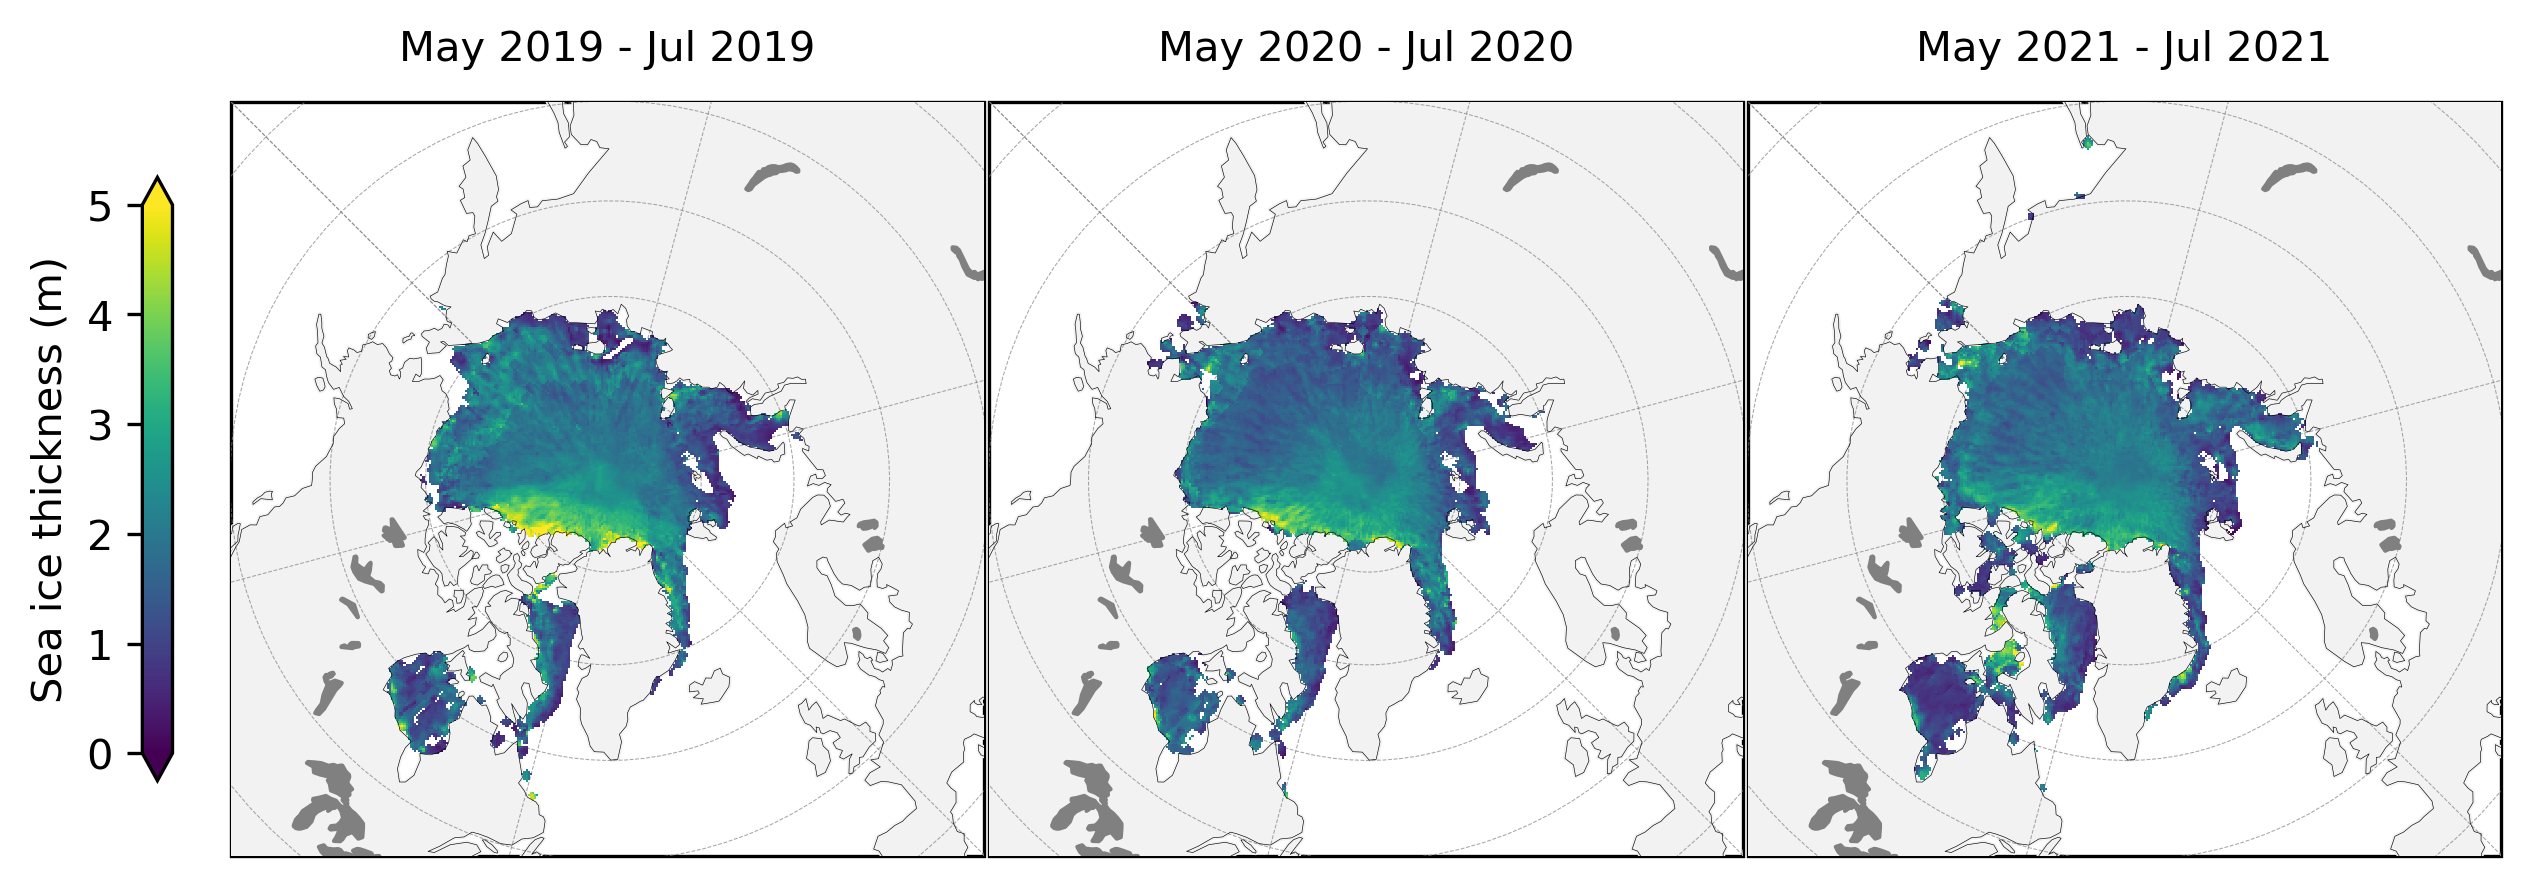

In [17]:
# Years over which to perform analysis (start year of that winter period)
years = [x for x in range(2019, 2021+1)]

thickness_summer_means = compute_gridcell_summer_means(IS2SITMOGR4_summer_v0.ice_thickness_sm_int, years=years)

staticArcticMaps(thickness_summer_means, dates=thickness_summer_means.time.values,title="", set_cbarlabel = "Sea ice thickness (m)", col_wrap=3, cmap="viridis", vmin=0, vmax=5, out_str='thickness_summer_2019_2021')

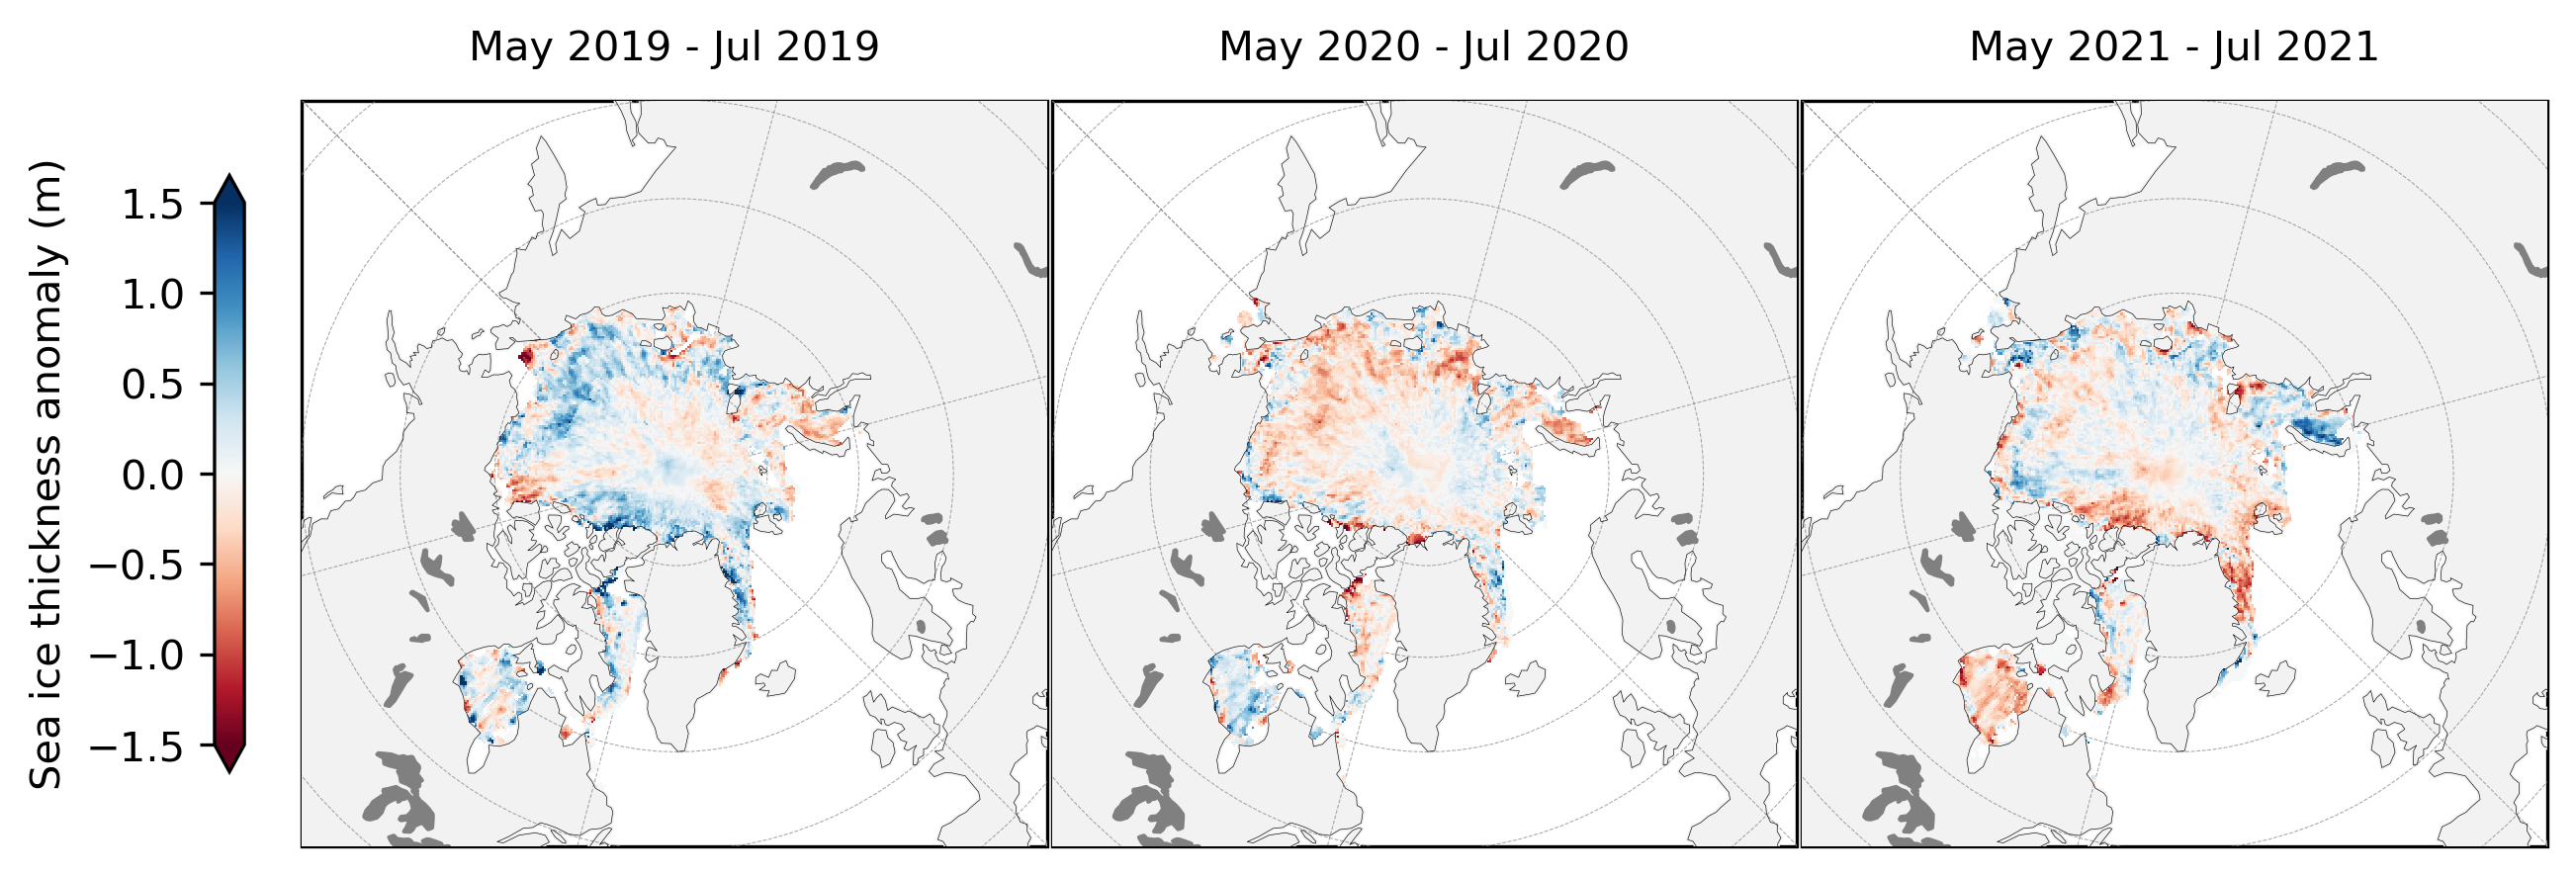

In [18]:

staticArcticMaps(thickness_summer_means-thickness_summer_means.mean(axis=0), dates=thickness_summer_means.time.values,title="", set_cbarlabel = "Sea ice thickness anomaly (m)", cmap="RdBu", vmin=-1.5, vmax=1.5,out_str='thickness_summer_anomaly_2019_2021')